In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-rna-3d-folding/sample_submission.csv
/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv
/kaggle/input/stanford-rna-3d-folding/test_sequences.csv
/kaggle/input/stanford-rna-3d-folding/validation_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_sequences.csv


In [29]:
import torch
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Upload the data

In [44]:
def load_data(source) -> pl.DataFrame:
    return pl.read_csv(source = source, truncate_ragged_lines = True)

In [45]:
#Load the data
train_sequences = load_data(source = "/kaggle/input/stanford-rna-3d-folding/train_sequences.csv")
train_labels = load_data(source = "/kaggle/input/stanford-rna-3d-folding/train_labels.csv")
test_sequences = load_data(source = "/kaggle/input/stanford-rna-3d-folding/test_sequences.csv")
valid_sequences = load_data(source = "/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv")
valid_labels = load_data(source = "/kaggle/input/stanford-rna-3d-folding/validation_labels.csv")
sample_submission = load_data(source = "/kaggle/input/stanford-rna-3d-folding/sample_submission.csv")

#Check for N/A
datasets = {
    "Train Sequences": train_sequences,
    "Train Labels": train_labels,
    "Test Sequences": test_sequences,
    "Validation Sequences": valid_sequences,
    "Validation Labels": valid_labels,
}

for name, df in datasets.items():
    null_counts = df.null_count().sum()
    print(f"N/A count for {name}: {null_counts}")

N/A count for Train Sequences: shape: (1, 5)
┌───────────┬──────────┬─────────────────┬─────────────┬───────────────┐
│ target_id ┆ sequence ┆ temporal_cutoff ┆ description ┆ all_sequences │
│ ---       ┆ ---      ┆ ---             ┆ ---         ┆ ---           │
│ u32       ┆ u32      ┆ u32             ┆ u32         ┆ u32           │
╞═══════════╪══════════╪═════════════════╪═════════════╪═══════════════╡
│ 0         ┆ 0        ┆ 0               ┆ 0           ┆ 5             │
└───────────┴──────────┴─────────────────┴─────────────┴───────────────┘
N/A count for Train Labels: shape: (1, 6)
┌─────┬─────────┬───────┬──────┬──────┬──────┐
│ ID  ┆ resname ┆ resid ┆ x_1  ┆ y_1  ┆ z_1  │
│ --- ┆ ---     ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ u32 ┆ u32     ┆ u32   ┆ u32  ┆ u32  ┆ u32  │
╞═════╪═════════╪═══════╪══════╪══════╪══════╡
│ 0   ┆ 0       ┆ 0     ┆ 6145 ┆ 6145 ┆ 6145 │
└─────┴─────────┴───────┴──────┴──────┴──────┘
N/A count for Test Sequences: shape: (1, 5)
┌───────────┬──────────┬─────

In [56]:
#Fill the N/A with 0 
print(train_sequences.fill_null(0))
print(train_labels.fill_null(0))

shape: (844, 5)
┌───────────┬──────────────────────┬─────────────────┬──────────────────────┬──────────────────────┐
│ target_id ┆ sequence             ┆ temporal_cutoff ┆ description          ┆ all_sequences        │
│ ---       ┆ ---                  ┆ ---             ┆ ---                  ┆ ---                  │
│ str       ┆ str                  ┆ str             ┆ str                  ┆ str                  │
╞═══════════╪══════════════════════╪═════════════════╪══════════════════════╪══════════════════════╡
│ 1SCL_A    ┆ GGGUGCUCAGUACGAGAGGA ┆ 1995-01-26      ┆ THE SARCIN-RICIN     ┆ >1SCL_1|Chain A|RNA  │
│           ┆ ACCGCACCC            ┆                 ┆ LOOP, A MODUL…       ┆ SARCIN-RIC…          │
│ 1RNK_A    ┆ GGCGCAGUGGGCUAGCGCCA ┆ 1995-02-27      ┆ THE STRUCTURE OF AN  ┆ >1RNK_1|Chain A|RNA  │
│           ┆ CUCAAAAGGC…          ┆                 ┆ RNA PSEUDO…          ┆ PSEUDOKNOT…          │
│ 1RHT_A    ┆ GGGACUGACGAUCACGCAGU ┆ 1995-06-03      ┆ 24-MER RNA HAIRPIN  

In [47]:
#Verifying the shape
print(f'The shapes of train data, train targets, test data are \n {train_sequences.shape}, {train_labels.shape}, {test_sequences.shape}')

The shapes of train data, train targets, test data are 
 (844, 5), (137095, 6), (12, 5)


In [48]:
class RNADataset(Dataset):
    def __init__(self, sequences: pl.DataFrame, labels: pl.DataFrame = None):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        self.sequences.shape[0]

    def __getitem__(self, idx):
        sequence = self.sequences[idx].to_dict()
        label = self.labels[idx].to_dict() if self.labels is not None else None
        return sequence, label

#Create a DataLoader
batch_size = 32
train_dataset = RNADataset(train_sequences, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size)

## Visualize

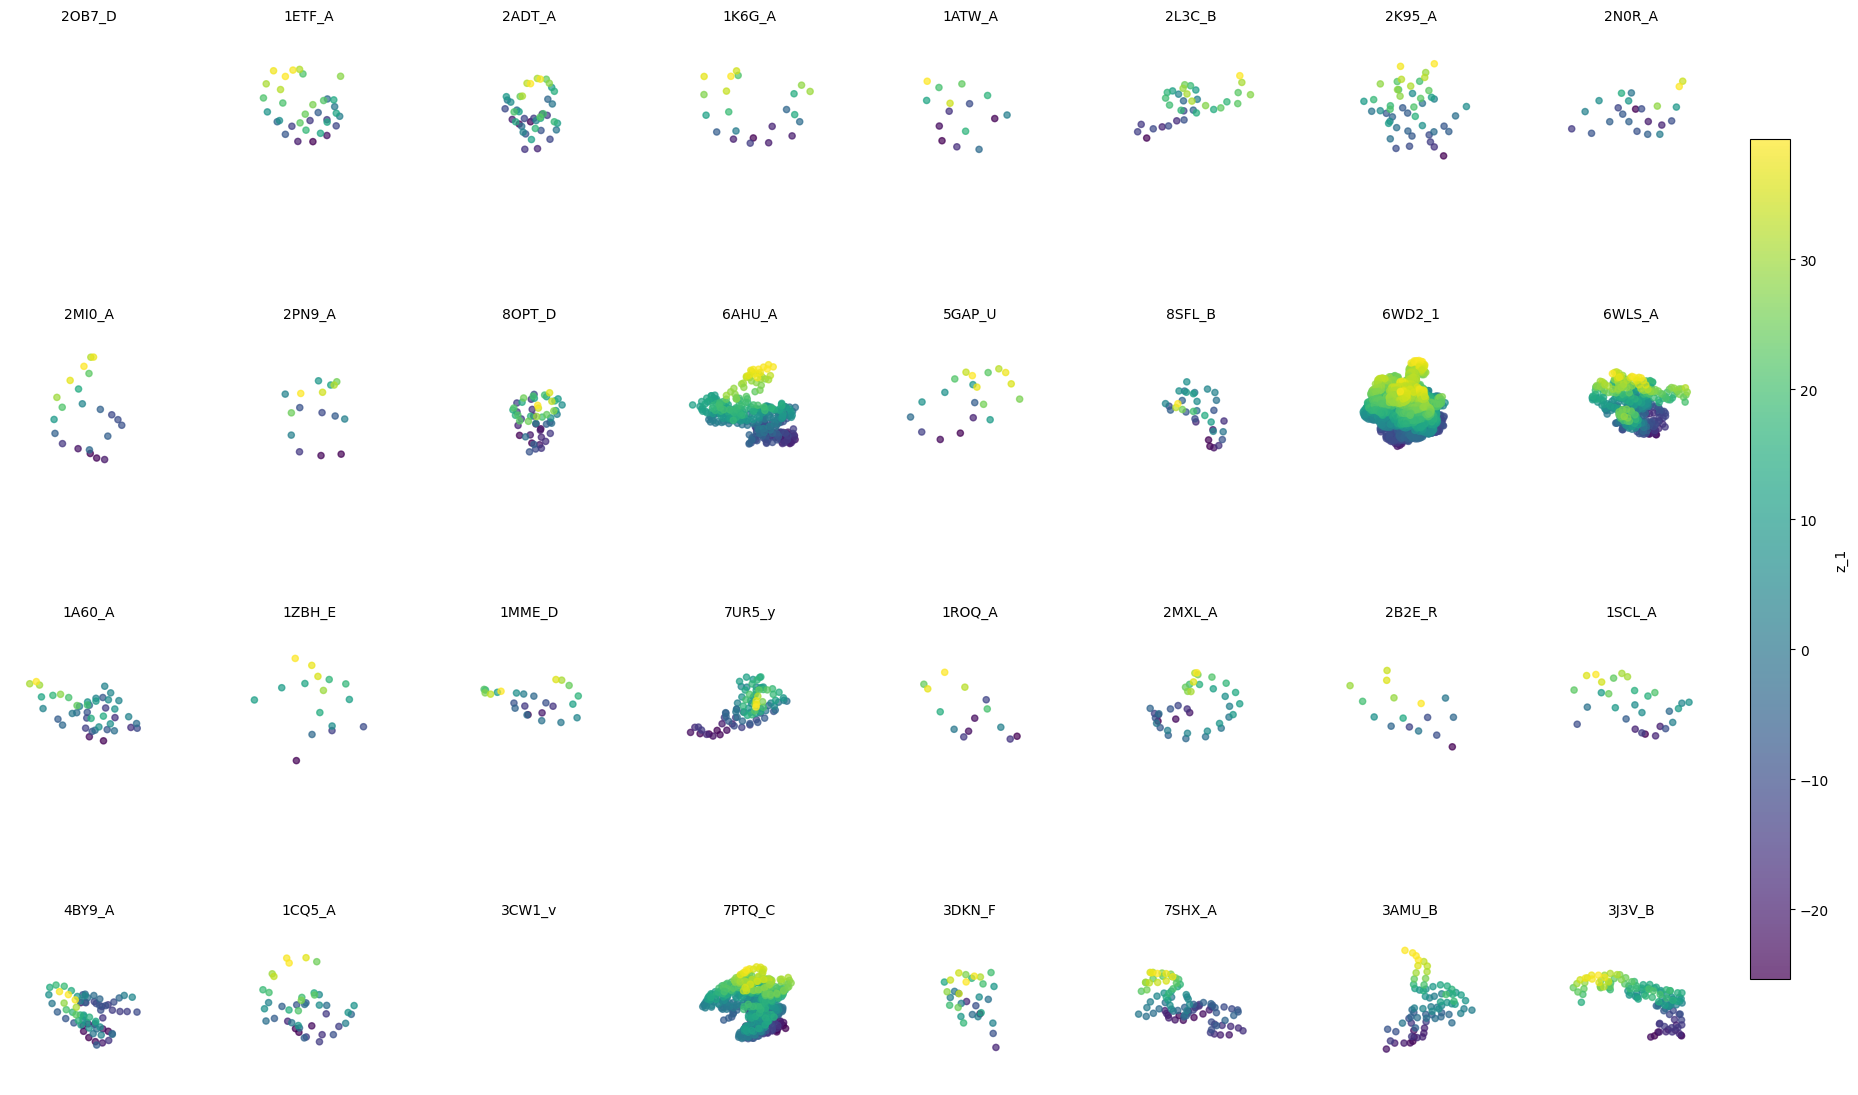

In [72]:
np.random.seed(42)
unique_target_ids = train_sequences['target_id'].unique().to_list()
idx = np.random.choice(len(unique_target_ids), size=32, replace=False)
selected_target_ids = [unique_target_ids[i] for i in idx]

#Figure with 4x8 subplots for 3D scatter plots
fig, axes = plt.subplots(4, 8, figsize=(20, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

#Visualize sample data in 3D scatter plots
for i, target_id in enumerate(selected_target_ids):
    axes[i].axis('off')  #Hide axis ticks
    
    #Get all labels corresponding to the current target_id
    filtered_data = train_labels.filter(pl.col('ID').str.starts_with(target_id)).sort('resid').to_dict(as_series=False)
    
    #Extract coordinates and residue names
    x = np.array(filtered_data['x_1'], dtype=float)
    y = np.array(filtered_data['y_1'], dtype=float)
    z = np.array(filtered_data['z_1'], dtype=float)
    
    sc = axes[i].scatter(x, y, z, c=z, cmap='viridis', alpha=0.7)
    
    axes[i].view_init(elev=30, azim=45)
    
    axes[i].set_title(f'{target_id}', color='black', fontsize=10, pad=10)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
fig.colorbar(sc, cax=cbar_ax, label='z_1', orientation='vertical')

fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.6)

plt.show()